In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

In [ ]:
!pip install simpleitk

     |████████████████████████████████| 47.4MB 117kB/s 


In [ ]:
import numpy as np
import random as r
import glob

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img = img.astype(np.float32)

        for slice in range(50,130):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (240,240))
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste)

In [ ]:
t1ce = train_array('/content/drive/MyDrive/project/Unet_Brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData/','**/*t1ce_nb4.nii.gz')

In [ ]:
t1ce_test = train_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*t1ce_nb4.nii.gz')

In [ ]:
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin='simpleitk')

        if label == 1:
          img[img != 0] = 1 #tam tümör
        elif label == 2:
          img[img != 1] = 0 #nekroz
        elif label == 3:
          img[img == 2] = 0
          img[img != 0] = 1 #ödemsiz tümör
        elif label == 4:
          img[img != 4] = 0
          img[img == 4] = 1 #genişleyen tümör

        img=img.astype(np.float32)

        for slice in range(50,130):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (240,240))
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste)

In [ ]:
seg_tam = seg_array('/content/drive/MyDrive/project/Unet_Brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData/','**/*seg.nii.gz',1)

In [ ]:
seg_tam_test = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*seg.nii.gz',1)

In [ ]:
seg_nekroz = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/','**/*seg.nii.gz',2)

In [ ]:
seg_nekroz_test = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*seg.nii.gz',2)

In [ ]:
seg_ödemsiz = seg_array('/content/drive/MyDrive/project/Unet_Brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData/','**/*seg.nii.gz',3)

In [ ]:
seg_ödemsiz_test = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*seg.nii.gz',3)

In [ ]:
seg_geniş = seg_array('/content/drive/MyDrive/project/Unet_Brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData/','**/*seg.nii.gz',4)

In [ ]:
seg_geniş_test = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*seg.nii.gz',4)

In [ ]:
seg_orj = seg_array('/content/drive/MyDrive/project/Unet_Brain_tumor_segmentation/MICCAI_BraTS2020_TrainingData/','**/*seg.nii.gz',0)

In [ ]:
seg_orj = seg_array('/content/drive/MyDrive/MICCAI_BraTS2020_TestingData/','**/*seg.nii.gz',0)

In [ ]:
!unzip /content/drive/MyDrive/x_train.zip

Archive:  /content/drive/MyDrive/x_train.zip
  inflating: x_train.npy             


In [ ]:
!unzip /content/drive/MyDrive/x_test.zip

Archive:  /content/drive/MyDrive/x_test.zip
  inflating: x_test.npy              


In [ ]:
x_train = np.load ('x_train.npy')

In [ ]:
x_test = np.load ('x_test.npy')

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf


def dice_coef(y_true, y_pred):
    smooth = 0.005
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

K.set_image_data_format('channels_first')

def wU_Net1():

    inputs = Input((2, 240 , 240))

    conv1 = Conv2D(70, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(70, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)

    conv2 = Conv2D(140, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(140, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)

    conv3 = Conv2D(280, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(280, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)

    conv4 = Conv2D(560, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(560, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)

    conv5 = Conv2D(1120, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1120, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up6 = Conv2DTranspose(560, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(560, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(560, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = Conv2DTranspose(280, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(280, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(280, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(140, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(140, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(140, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(70, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(70, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(70, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model_tam= wU_Net1()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_tam.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_tam.fit(x_train, seg_tam,
          validation_data = (x_test,seg_tam_test),
          epochs = 30,
          batch_size = 3,
          shuffle = True)

Epoch 1/30
7894/7894 [==============================] - 1100s 134ms/step - loss: 0.4187 - dice_coef: 0.5813 - val_loss: 0.5744 - val_dice_coef: 0.4255
Epoch 2/30
7894/7894 [==============================] - 1047s 133ms/step - loss: 0.1844 - dice_coef: 0.8156 - val_loss: 0.4604 - val_dice_coef: 0.5396
Epoch 3/30
7894/7894 [==============================] - 1045s 132ms/step - loss: 0.1712 - dice_coef: 0.8288 - val_loss: 0.3261 - val_dice_coef: 0.6739
Epoch 4/30
7894/7894 [==============================] - 1044s 132ms/step - loss: 0.1563 - dice_coef: 0.8437 - val_loss: 0.2995 - val_dice_coef: 0.7004
Epoch 5/30
7894/7894 [==============================] - 1042s 132ms/step - loss: 0.1605 - dice_coef: 0.8395 - val_loss: 0.2803 - val_dice_coef: 0.7197
Epoch 6/30
7894/7894 [==============================] - 1040s 132ms/step - loss: 0.1571 - dice_coef: 0.8429 - val_loss: 0.3039 - val_dice_coef: 0.6961
Epoch 7/30
5512/7894 [===================>..........] - ETA: 4:53 - loss: 0.1381 - dice_coef: 

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice coef')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_tam.load_weights('/content/drive/MyDrive/model_wU_Net.h5')

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf


def dice_coef(y_true, y_pred):
    smooth = 0.005
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

K.set_image_data_format('channels_first')

def wU_Net():

    inputs = Input((1, 240 , 240))

    conv1 = Conv2D(70, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(70, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)

    conv2 = Conv2D(140, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(140, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)

    conv3 = Conv2D(280, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(280, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)

    conv4 = Conv2D(560, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(560, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)

    conv5 = Conv2D(1120, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1120, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up6 = Conv2DTranspose(560, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(560, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(560, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = Conv2DTranspose(280, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(280, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(280, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(140, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(140, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(140, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(70, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(70, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(70, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model_ödemsiz = wU_Net()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_genis = wU_Net()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_genis.load_weights('/content/drive/MyDrive/model_wU_Net_geniş.h5')

In [ ]:
model_ödemsiz.load_weights('/content/drive/MyDrive/model_wunet_ödemsiz.h5')

In [ ]:
def isnan(value):
  try:
      import math
      return math.isnan(float(value))
  except:
      return False

In [ ]:
sum_sensitivity=0
mean_sensitivity=0

sum_dice=0
mean_dice=0
a=0
for i in range(0,len(seg_tam_test)):
  pred_tam = model_tam.predict(np.expand_dims(x_test[i,:,:,:],axis=0))
  t1ce_tam = pred_tam[0] * t1ce_test[i]
  expand_img = np.expand_dims(t1ce_tam,axis=0)
  pred_ödemsiz = model_ödemsiz.predict(expand_img)
  t1ce_ödemsiz = pred_ödemsiz[0]*t1ce_test[i]
  expand_img = np.expand_dims(t1ce_ödemsiz,axis=0)
  pred_geniş = model_genis.predict(expand_img)
  dice = compute_dice(pred_tam[0,0,:,:],seg_tam_test[i,0,:,:])
  r = sensitivity(pred_tam[0,0,:,:],seg_tam_test[i,0,:,:])
  sum_dice = sum_dice + dice
  if isnan(r) == False:
    sum_sensitivity = r + sum_sensitivity
    a=a+1
  else:
    r=0
    sum_sensitivity = r+sum_sensitivity


mean_dice = sum_dice / len(seg_ödemsiz_test)
mean_sensitivity = sum_sensitivity / len(seg_tam_test)


print(mean_dice, mean_sensitivity)

NameError: ignored

In [ ]:
def sensitivity(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1>0.5).astype(np.bool)
    im2 = np.asarray(im2>0.5).astype(np.bool)
    FN=0

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    TP = np.logical_and(im1, im2)

    return TP.sum() / im2.sum()

In [ ]:
def üstüne_ekle(pred_tam, pred_ödemsiz , pred_geniş ):

    total = np.zeros((1,1,240,240),np.float32)
    total[:,:,:,:] = pred_tam[:,:,:,:]

    for i in range(pred_ödemsiz.shape[0]):
        for j in range(240):
            for k in range(240):

                if pred_ödemsiz[i,0,j,k] != 0 and pred_tam[i,0,j,k] !=0:
                    total[i,0,j,k] = pred_ödemsiz[i,0,j,k]

                if pred_geniş[i,0,j,k] != 0 and pred_tam[i,0,j,k] !=0:
                    total[i,0,j,k] = pred_geniş[i,0,j,k]

    return total

In [ ]:
pred_tam = model_tam.predict(x_test)
t1ce_tam = pred_tam * t1ce_test
expand_img = np.expand_dims(t1ce_tam,axis=0)
pred_ödemsiz = model_ödemsiz.predict(t1ce_tam)
t1ce_ödemsiz = pred_ödemsiz*t1ce_test
expand_img = np.expand_dims(t1ce_ödemsiz,axis=0)
pred_geniş = model_genis.predict(t1ce_ödemsiz)

In [ ]:
orj=show_lable_on_image4(x_test[4848,0], seg_orj[4848,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


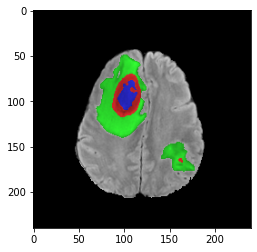

In [ ]:
plt.imshow(orj)

In [ ]:
a=show_lable_on_image4(x_test[4848,0], seg[0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


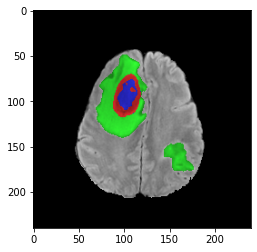

In [ ]:
plt.imshow(a)

In [ ]:
from skimage import io, color, img_as_float
def show_lable_on_image4(test_img, label_im):

    alpha = 0.8

    img = img_as_float(test_img/test_img.max())
    rows, cols = img.shape

    # Construct a colour image to superimpose
    color_mask = np.zeros((rows, cols, 3))
    red_multiplier = [1, 0.2, 0.2]
    green_multiplier = [0.35,0.75,0.25]
    blue_multiplier = [0,0.25,0.9]
    yellow_multiplier = [1,1,0.25]
    brown_miltiplier = [40./255, 26./255, 13./255]


    color_mask[label_im==1] = [0, 0, 1]  # Red block
    color_mask[label_im==2] = [0, 1, 0] # Green block
    color_mask[label_im==3] = [0, 0, 1] # Blue block
    color_mask[label_im==4] = [1, 0, 0] # Yellow block

    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))

    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)

    return img_masked

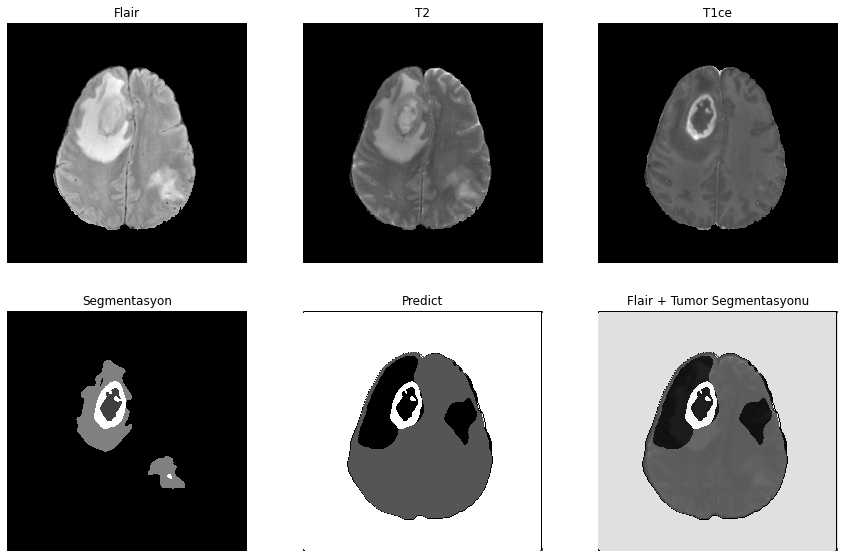

In [ ]:
renk = { 0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a  = 2
x=4848

pred_tam = model_tam.predict(np.expand_dims(x_test[x,:,:,:],axis=0))
t1ce_tam = pred_tam[0] * t1ce_test[x]
expand_img = np.expand_dims(t1ce_tam,axis=0)
pred_ödemsiz = model_ödemsiz.predict(expand_img)
t1ce_ödemsiz = pred_ödemsiz[0] * t1ce_test[x]
expand_img = np.expand_dims(t1ce_ödemsiz,axis=0)
pred_genis = model_genis.predict(expand_img)
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0
pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0
pred_genis[pred_genis > 0.2] = 4
pred_genis[pred_genis != 4 ] = 0
seg = üstüne_ekle(pred_tam, pred_ödemsiz, pred_genis)
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.title('Flair')
plt.axis('off')
plt.imshow(x_test[x, 0, :, :], cmap= renk[a])

plt.subplot(332)
plt.title('T2')
plt.axis('off')
plt.imshow(x_test[x, 1, :, :],cmap= renk[a])

plt.subplot(333)
plt.title('T1ce')
plt.axis('off')
plt.imshow(t1ce_test[x, 0, :, :],cmap= renk[a])

plt.subplot(334)
plt.title('Segmentasyon')
plt.axis('off')
plt.imshow(seg_orj[x, 0, :, :],cmap= renk[a])

plt.subplot(335)
plt.title('Predict')
plt.axis('off')
plt.imshow(seg[0, 0, :, :],cmap= renk[a])


plt.subplot(336)
plt.title('Flair + Tumor Segmentasyonu')
plt.axis('off')
y = cv2.addWeighted(x_test[x,1,:,:],0.1, seg[0,0,:,:], 0.9,0)
plt.imshow(y, cmap= renk[a])

In [ ]:
orj=show_lable_on_image4(x_test[197,0], seg[0,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


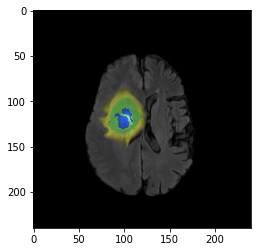

In [ ]:
plt.imshow(orj)

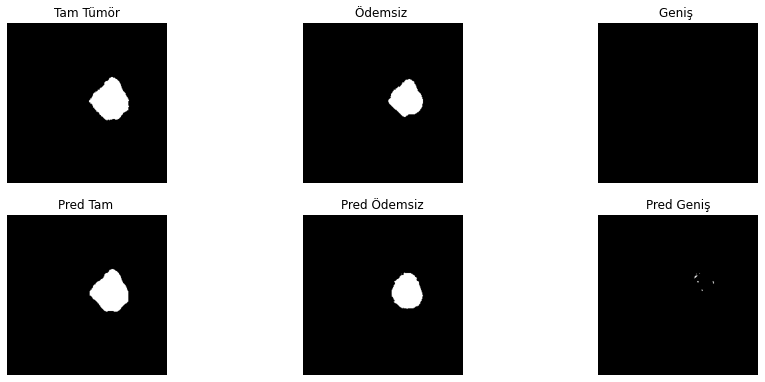

In [ ]:
renk = { 0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a  = 2
x=4000

pred_tam = model_tam.predict(np.expand_dims(x_test[x,:,:,:],axis=0))
t1ce_tam = pred_tam[0] * t1ce_test[x]
expand_img = np.expand_dims(t1ce_tam,axis=0)
pred_ödemsiz = model_ödemsiz.predict(expand_img)
t1ce_ödemsiz = pred_ödemsiz[0] * t1ce_test[x]
expand_img = np.expand_dims(t1ce_ödemsiz,axis=0)
pred_genis = model_genis.predict(expand_img)
b = cv2.add(pred_tam, pred_ödemsiz)
c = cv2.add(pred_genis, b)
total = np.zeros((1,240,240),np.float32)
total = c
plt.figure(figsize=(15,10))

plt.subplot(331)
plt.title('Tam Tümör')
plt.axis('off')
plt.imshow(seg_tam_test[x,0 ,:,:],cmap= renk[a])

plt.subplot(332)
plt.title('Ödemsiz ')
plt.axis('off')
plt.imshow(seg_ödemsiz_test[x, 0, :, :],cmap= renk[a])

plt.subplot(333)
plt.title('Geniş ')
plt.axis('off')
plt.imshow(seg_geniş_test[x, 0, :, :],cmap= renk[a])


plt.subplot(334)
plt.title('Pred Tam ')
plt.axis('off')
plt.imshow(pred_tam[0,0,:,:],cmap= renk[a])


plt.subplot(335)
plt.title('Pred Ödemsiz')
plt.axis('off')
plt.imshow(pred_ödemsiz[ 0, 0, :, :],cmap= renk[a])


plt.subplot(336)
plt.title('Pred Geniş')
plt.axis('off')
plt.imshow(pred_genis[ 0, 0, :, :],cmap= renk[a])


In [ ]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(seg_tam_test[x][0], pred_tam[0][0])
dice = compute_dice(seg_tam_test[x][0], pred_tam[0][0])
print ('WT Sensitivity:', sensitivity)
print ('WT Specificity:', specificity)
print ('WT Accuracy:', accuracy)
print ('WT Dice:', dice)
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(seg_ödemsiz_test[x][0], pred_ödemsiz[0][0])
dice = compute_dice(seg_ödemsiz_test[x][0], pred_ödemsiz[0][0])
print ('TC Sensitivity:', sensitivity)
print ('TC Specificity:', specificity)
print ('TC Accuracy:', accuracy)
print ('TC Dice:', dice)
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(seg_geniş_test[x][0], pred_genis[0][0])
dice = compute_dice(seg_geniş_test[x][0], pred_genis[0][0])
print ('ET Sensitivity:', sensitivity)
print ('ET Specificity:', specificity)
print ('ET Accuracy:', accuracy)
print ('ET Dice:', dice)

WT Sensitivity: 0.0
WT Specificity: 0.9977949695406809
WT Accuracy: 0.9270138888888889
WT Dice: 0.9775021281770643
TC Sensitivity: 0.9465381244522348
TC Specificity: 0.9999645760640464
TC Accuracy: 0.99890625
TC Dice: 0.97165991902834
ET Sensitivity: 0.0
ET Specificity: 0.9999120910033933
ET Accuracy: 0.9873611111111111
ET Dice: 0.9246676514032496


In [ ]:
def compute_dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1>0.5).astype(np.bool)
    im2 = np.asarray(im2>0.5).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [ ]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary.
    # This would allow return of other measures other than sensitivity and specificity

    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0

    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)

    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)

    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)

    return sensitivity, specificity, accuracy

Tam Tümör

In [ ]:
sum_dice=0
mean_dice=0
for i in range(1,len(seg_tam_test)):
  pred_tam = model_tam.predict(x_test[i-1:i,:,:,:])
  dice = compute_dice(pred_tam[0,0,:,:],seg_tam_test[i,0,:,:])
  sum_dice = sum_dice + dice
mean_dice = sum_dice / len(seg_tam_test)
print(mean_dice)

InvalidArgumentError: ignored

In [ ]:
sum_sensitivity=0
mean_sensitivity=0
sum_specifity=0
mean_specifity=0
sum_accuracy=0
mean_accuracy=0
sum_dice=0
mean_dice=0
for i in range(0,len(seg_tam_test)):
  pred_tam = model_tam.predict(np.expand_dims(x_test[i,:,:,:],axis=0))
  dice = compute_dice(pred_tam[0,0,:,:],seg_tam_test[i,0,:,:])
  sensitivity, specifity, accuracy = calculate_sensitivity_specificity(seg_tam_test[i][0], pred_tam[0][0])
  sum_dice = sum_dice + dice
  sum_sensitivity = sum_sensitivity + sensitivity
  sum_specifity = sum_specifity + specifity
  sum_accuracy = sum_accuracy + accuracy
mean_dice = sum_dice / len(seg_tam_test)
mean_sensitivity = sum_sensitivity / len(seg_tam_test)
mean_specifity = sum_specifity / len(seg_tam_test)
mean_accuracy = sum_accuracy / len(seg_tam_test)

print(mean_dice, mean_sensitivity, mean_specifity, mean_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


0.8229860686556393 nan 0.0021725927879466807 0.02180108150209284


Tümör Merkezi (Ödemsiz Tümör)

In [ ]:
sum_sensitivity=0
mean_sensitivity=0
sum_specifity=0
mean_specifity=0
sum_accuracy=0
mean_accuracy=0
sum_dice=0
mean_dice=0
a=0
for i in range(0,len(seg_tam_test)):
  pred_tam = model_tam.predict(np.expand_dims(x_test[i,:,:,:],axis=0))
  t1ce_tam = pred_tam[0] * t1ce_test[i]
  expand_img = np.expand_dims(t1ce_tam,axis=0)
  pred_ödemsiz = model_ödemsiz.predict(expand_img)
  dice = compute_dice(pred_ödemsiz[0,0,:,:],seg_ödemsiz_test[i,0,:,:])
  sensitivity, specifity, accuracy = calculate_sensitivity_specificity(seg_ödemsiz_test[i][0], pred_ödemsiz[0][0])
  sum_dice = sum_dice + dice
  if sensitivity != 'nan':
    sum_sensitivity = sum_sensitivity + sensitivity
    a=a+1

  sum_specifity = sum_specifity + specifity
  sum_accuracy = sum_accuracy + accuracy
mean_dice = sum_dice / len(seg_ödemsiz_test)
mean_sensitivity = sum_sensitivity / a
mean_specifity = sum_specifity / len(seg_ödemsiz_test)
mean_accuracy = sum_accuracy / len(seg_ödemsiz_test)

print(mean_dice, mean_sensitivity, mean_specifity, mean_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


0.7542894171625046 nan 0.9982338020822542 0.9944252253377089


Genişleyen Tümör

In [ ]:
sum_sensitivity=0
mean_sensitivity=0
sum_specifity=0
mean_specifity=0
sum_accuracy=0
mean_accuracy=0
sum_dice=0
mean_dice=0
for i in range(0,len(seg_tam_test)):
  pred_tam = model_tam.predict(np.expand_dims(x_test[i,:,:,:],axis=0))
  t1ce_tam = pred_tam[0] * t1ce_test[i]
  expand_img = np.expand_dims(t1ce_tam,axis=0)
  pred_ödemsiz = model_ödemsiz.predict(expand_img)
  t1ce_ödemsiz = pred_ödemsiz[0]*t1ce_test[i]
  expand_img = np.expand_dims(t1ce_ödemsiz,axis=0)
  pred_geniş = model_genis.predict(expand_img)
  dice = compute_dice(pred_geniş[0,0,:,:],seg_geniş_test[i,0,:,:])
  sensitivity, specifity, accuracy = calculate_sensitivity_specificity(seg_geniş_test[i][0], pred_geniş[0][0])
  sum_dice = sum_dice + dice
  sum_sensitivity = sum_sensitivity + sensitivity
  sum_specifity = sum_specifity + specifity
  sum_accuracy = sum_accuracy + accuracy
mean_dice = sum_dice / len(seg_ödemsiz_test)
mean_sensitivity = sum_sensitivity / len(seg_ödemsiz_test)
mean_specifity = sum_specifity / len(seg_ödemsiz_test)
mean_accuracy = sum_accuracy / len(seg_ödemsiz_test)

print(mean_dice, mean_sensitivity, mean_specifity, mean_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


0.7141453836811085 nan 0.009327492894386903 0.011292424728881286
